In [3]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen','Yuanheng','Lillian','Ren']
ACTIVITIES = ['sit','walk','upstair','downstair']
CHUNK_SIZE = 2  # in seconds
START_FROM, END_TO = 200, 300
NUM_CLASSES = 4

In [4]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=1500, time_end=7500):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [9]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // (chunk_size * 100)
        for j in range(num_chunks):
            x = list(data_raw[i]["x"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            y = list(data_raw[i]["y"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            z = list(data_raw[i]["z"])[j * chunk_size * 100:(j + 1) * chunk_size * 100]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES)

In [10]:
# Convert to torch tensors
X_train = torch.tensor(training_data, dtype=torch.float32)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(testing_data, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Reshape X_train and X_test to the correct format for LSTM (batch_size, seq_length, input_size)
X_train = X_train.permute(0, 2, 1)
X_test = X_test.permute(0, 2, 1)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [11]:
# Define the improved LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        out = self.batch_norm(last_time_step_out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Initialize model, optimizer, and loss function
model = LSTMModel(input_size=3, hidden_size=128, num_classes=NUM_CLASSES)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-5)

# Early Stopping Setup
best_loss = float('inf')
patience = 5
epochs_since_improvement = 0

In [12]:
# Training loop with validation and early stopping
epochs = 30
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Early stopping
  #  if avg_loss < best_loss:
     #   best_loss = avg_loss
      #  epochs_since_improvement = 0
   # else:
     #   epochs_since_improvement += 1
      #  if epochs_since_improvement >= patience:
        #    print(f"Early stopping at epoch {epoch+1}")
         #   break

Epoch [1/30], Loss: 1.5211
Epoch [2/30], Loss: 1.1311
Epoch [3/30], Loss: 1.1606
Epoch [4/30], Loss: 1.2204
Epoch [5/30], Loss: 0.9996
Epoch [6/30], Loss: 1.1646
Epoch [7/30], Loss: 1.1878
Epoch [8/30], Loss: 1.1480
Epoch [9/30], Loss: 1.1425
Epoch [10/30], Loss: 1.2576
Epoch [11/30], Loss: 1.0894
Epoch [12/30], Loss: 1.1001
Epoch [13/30], Loss: 1.1686
Epoch [14/30], Loss: 1.1771
Epoch [15/30], Loss: 1.2063
Epoch [16/30], Loss: 1.2096
Epoch [17/30], Loss: 1.0770
Epoch [18/30], Loss: 1.1282
Epoch [19/30], Loss: 0.9954
Epoch [20/30], Loss: 1.0594
Epoch [21/30], Loss: 1.0760
Epoch [22/30], Loss: 1.1356
Epoch [23/30], Loss: 1.1136
Epoch [24/30], Loss: 1.0544
Epoch [25/30], Loss: 1.1971
Epoch [26/30], Loss: 1.0912
Epoch [27/30], Loss: 1.0175
Epoch [28/30], Loss: 1.1796
Epoch [29/30], Loss: 1.0733
Epoch [30/30], Loss: 1.0272


In [43]:
torch.save(model.state_dict(), 'model.pth')

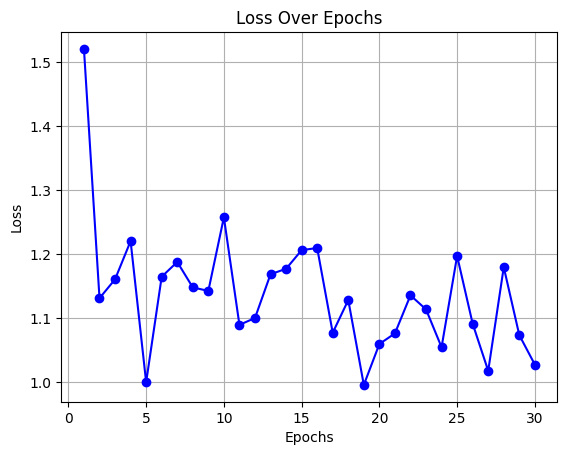

In [13]:
# Plot the loss graph
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [1]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

KeyboardInterrupt: 